In [284]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from datetime import datetime
from torch.utils.data import DataLoader, Dataset

torch.set_default_dtype(torch.float64)

plt.style.use('default')
plt.rcParams['font.size'] = '14'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from accelerate import Accelerator
accelerator = Accelerator()

Task 1: Load data

In [285]:
# Load data
data = torch.from_numpy(
           np.genfromtxt (
               'weather.csv',
               delimiter = ",",
               skip_header=1,
               dtype = float ) )

print(f"\nNumber of samples: {data.shape[0]}")
print(f"Number of variables: {data.shape[1]}\n")


Number of samples: 52696
Number of variables: 22



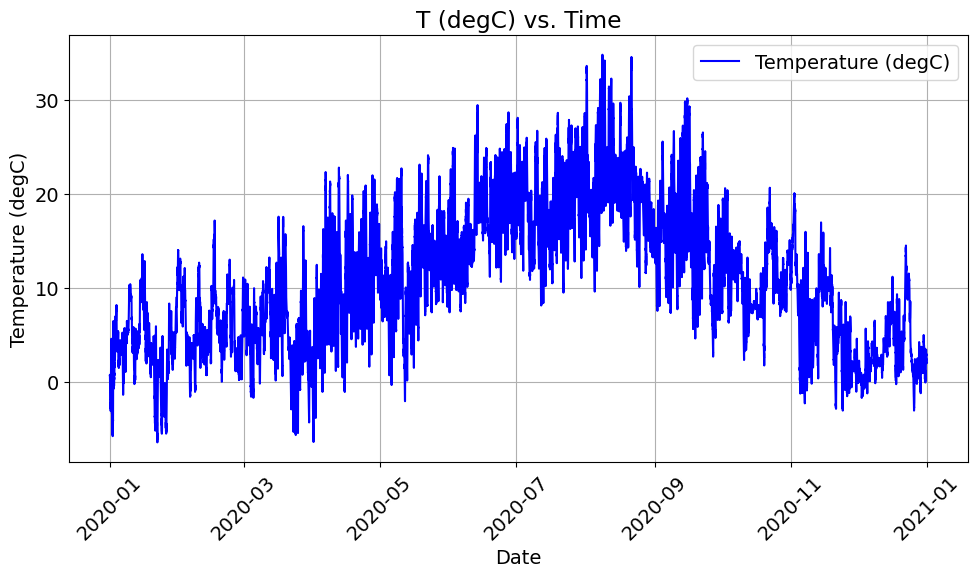

In [286]:
# Plot T(degC) vs. Time
date_strs = np.genfromtxt(
    'weather.csv',
    delimiter=",",
    skip_header=1,
    usecols=0,
    dtype=str
)

# Convert date strings to datetime objects
timesteps = [datetime.strptime(date, '%Y-%m-%d %H:%M:%S') for date in date_strs]

# Extract the temperature column
temperatures = data[:, 2].numpy()

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(timesteps, temperatures, label='Temperature (degC)', color='blue')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Temperature (degC)')
plt.title('T (degC) vs. Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [287]:
# Convert dates and times to numbers
times = torch.tensor(
    [datetime.strptime(date, '%Y-%m-%d %H:%M:%S').timestamp() for date in date_strs],
    dtype=torch.float
).unsqueeze(1)
data[:, 0] = times[:, 0]/ 1e+9

# y = T(degC), x include all 12 features
prop = [5, 6, 7, 8, 9, 10, 13, 14, 15, 16, 17, 18]
x = data[:, [prop[i] for i in range(12)]].float()
y = data[:, 2].float()

# Split into testing and training datasets
train_len = int(0.7*len(data))

train_x = x[0:train_len]
train_y = y[0:train_len]

test_x = x[train_len:]
test_y = y[train_len:]

In [288]:
window_size = 100
step_size = 10
batch_size = 100

# Split x into windows
class Windowed_X_Dataset(Dataset):
    def __init__(self, x, y, window_size, step_size):
        self.x = x
        self.y = y
        self.window_size = window_size
        self.step_size = step_size

    def __len__(self):
        return (self.x.shape[0] - self.window_size - 1) // self.step_size + 1

    def __getitem__(self, idx):
        start_idx = idx * self.step_size
        end_idx = start_idx + self.window_size
        x_window = self.x[start_idx:end_idx]
        y = self.y[end_idx]
        return x_window, y

train_dataset = Windowed_X_Dataset(train_x, train_y, window_size, step_size)
test_dataset = Windowed_X_Dataset(test_x, test_y, window_size, step_size)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [289]:
def plot_loss(train_losses, title):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label= 'Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title + ': Training Loss')
    plt.legend()
    plt.show()

In [290]:
def plot_compare_prediction(predictions, actual, title):
    plt.figure(figsize=(12,7))
    plt.plot(actual, label='Actual')
    plt.plot(predictions, label='Predicted')
    plt.xlabel('Sample')
    plt.ylabel('Temperature')
    plt.legend()
    plt.title(title + ': Model Predictions vs Actual Temperatures')
    plt.show()

Task 2: Softmax self-attention module

In [291]:
# Masked softmax self-attention
class Self_Attention(nn.Module):
    def __init__(self, D, d_k, d_v, N, mask):
        super(Self_Attention, self).__init__()
        self.d_k = d_k
        self.d_v = d_v
        self.query = nn.Linear(D, self.d_k, bias=False)
        self.key = nn.Linear(D, self.d_k, bias=False)
        self.value = nn.Linear(D, self.d_v, bias=False)
        self.mask = mask
        self.register_buffer("tril",torch.tril(torch.ones((N,N)))) # used to store things that are not params.

    def forward(self, Q, K, V):
        B, T, C = Q.shape

        Q = self.query(Q)
        K = self.key(K)
        V = self.value(V)

        QK_T = torch.matmul(Q, K.transpose(-2, -1))
        if self.mask:
            QK_T = QK_T.masked_fill(self.tril[:T,:T]==0,float('-inf'))

        att = torch.matmul(F.softmax(QK_T/self.d_k**-0.5, dim=-1), V).squeeze()
        
        return att.view(B, T, self.d_k)

Task 3: Unmasked softmax self-attention model

In [292]:
class Single_Attention(nn.Module):
    def __init__(self, D, N):
        super(Single_Attention, self).__init__()
        self.self_attention = Self_Attention(D, D, D, N, False)
        self.flatten = nn.Linear(D * N, 1)
    
    def forward(self, X):
        X = self.self_attention(X, X, X)
        X = X.reshape(X.shape[0], -1)
        X = self.flatten(X)
        return X.squeeze()

In [293]:
D = 12
N = window_size

model_att = Single_Attention(D, N).float()
optimizer_att = torch.optim.Adam(model_att.parameters(), lr=1e-4)

compute_loss = nn.MSELoss()

train_loader, test_loader, model_att, optimizer_att = accelerator.prepare(
    train_loader, test_loader, model_att, optimizer_att
)

Epoch [10/100], Loss: 589.1820
Epoch [20/100], Loss: 278.4680
Epoch [30/100], Loss: 150.9972
Epoch [40/100], Loss: 90.5202
Epoch [50/100], Loss: 54.9822
Epoch [60/100], Loss: 35.5261
Epoch [70/100], Loss: 25.3040
Epoch [80/100], Loss: 20.6103
Epoch [90/100], Loss: 17.1608
Epoch [100/100], Loss: 15.8468


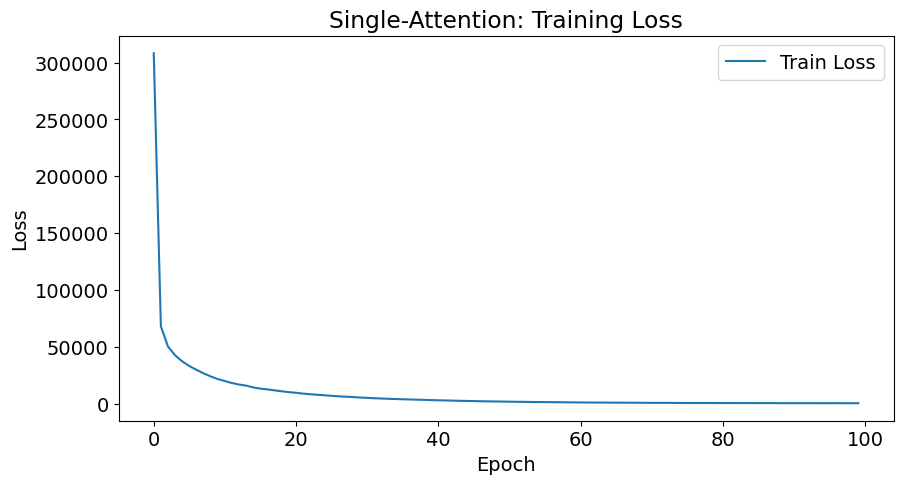

In [294]:
# Training
num_epochs = 100
model_att.train()
training_losses = []

for epoch in range(num_epochs):
    train_loss = 0.
    for inputs, targets in train_loader:
        output = model_att(inputs)
        loss = compute_loss(output, targets)
        train_loss += loss.item()
        
        optimizer_att.zero_grad()
        accelerator.backward(loss)
        optimizer_att.step()

    training_losses.append(train_loss)
    if (epoch+1)%10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {train_loss/len(train_loader):.4f}')
plot_loss(training_losses, 'Single-Attention')

Test Loss: 12.5009


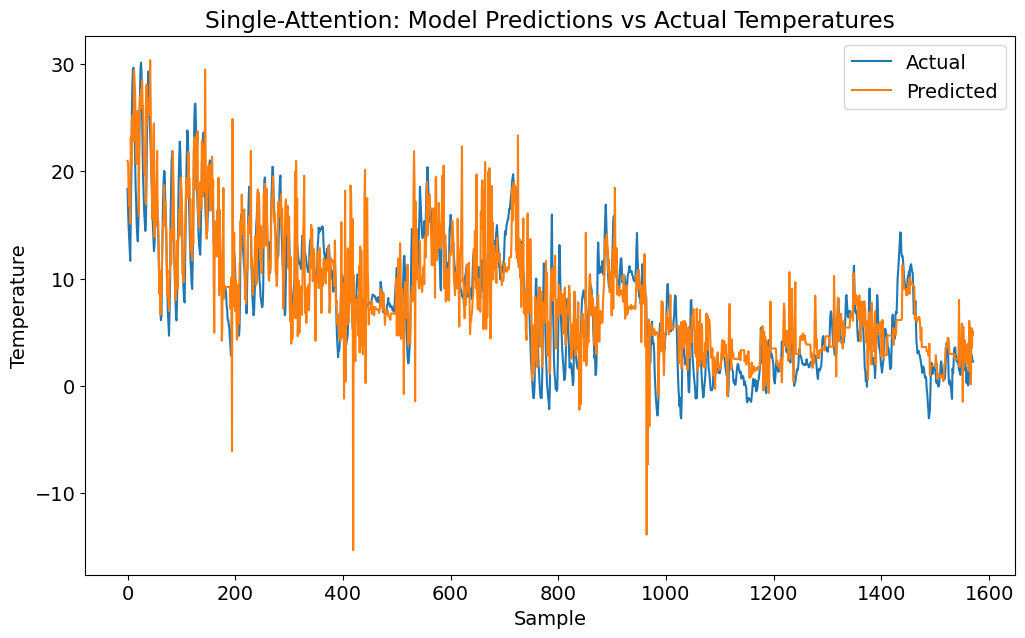

In [295]:
# Testing
model_att.eval()
predictions_a = []
actual_a = []

with torch.no_grad():
    test_loss = 0.
    for inputs, targets in test_loader:
        output = model_att(inputs)
        loss = compute_loss(output, targets)
        test_loss += loss.item()

        predictions_a.extend(output.flatten().tolist())
        actual_a.extend(targets.flatten().tolist())

    print(f'Test Loss: {test_loss/len(test_loader):.4f}')

# Visualize output
predictions_a = np.array(predictions_a)
actual_a = np.array(actual_a)
plot_compare_prediction(predictions_a, actual_a, 'Single-Attention')

Task 4: Multi-headed attention module

In [296]:
# Multi-headed attention
class Multi_Head_Attention(nn.Module):
    def __init__(self, D, K, N, mask):
        super(Multi_Head_Attention, self).__init__()
        self.K = K
        self.d_k = D//K
        self.d_v = D//K
        self.self_attention = Self_Attention(D, self.d_k, self.d_v, N, mask)
        self.W_O = nn.Linear(D, D, bias=False)

    def forward(self, Q, K, V):
        B, T, C = Q.shape
        att = self.self_attention(Q, K, V)
        att = torch.cat([att] * self.K, dim=2)
        H = self.W_O(att)

        return H.view(B, T, C)

Task 5: Unmasked multi-headed self-attention model

In [297]:
class Multi_Attention(nn.Module):
    def __init__(self, D, K, N):
        super(Multi_Attention, self).__init__()
        self.self_att = Multi_Head_Attention(D, K, N, False)
        self.flatten = nn.Linear(D * N, 1)
    
    def forward(self, X):
        X = self.self_att(X, X, X)
        X = X.reshape(X.shape[0], -1)
        X = self.flatten(X)
        return X.squeeze()

In [298]:
D = 12
K = 4
N = window_size

model_multi_att = Multi_Attention(D, K, N).float()
optimizer_multi_att = torch.optim.Adam(model_multi_att.parameters(), lr=1e-4)

compute_loss = nn.MSELoss()

train_loader, test_loader, model_multi_att, optimizer_multi_att = accelerator.prepare(
    train_loader, test_loader, model_multi_att, optimizer_multi_att
)

Epoch [10/100], Loss: 82.2181
Epoch [20/100], Loss: 53.2740
Epoch [30/100], Loss: 38.6370
Epoch [40/100], Loss: 28.7094
Epoch [50/100], Loss: 21.2137
Epoch [60/100], Loss: 15.9956
Epoch [70/100], Loss: 13.6743
Epoch [80/100], Loss: 12.7586
Epoch [90/100], Loss: 12.3722
Epoch [100/100], Loss: 11.8562


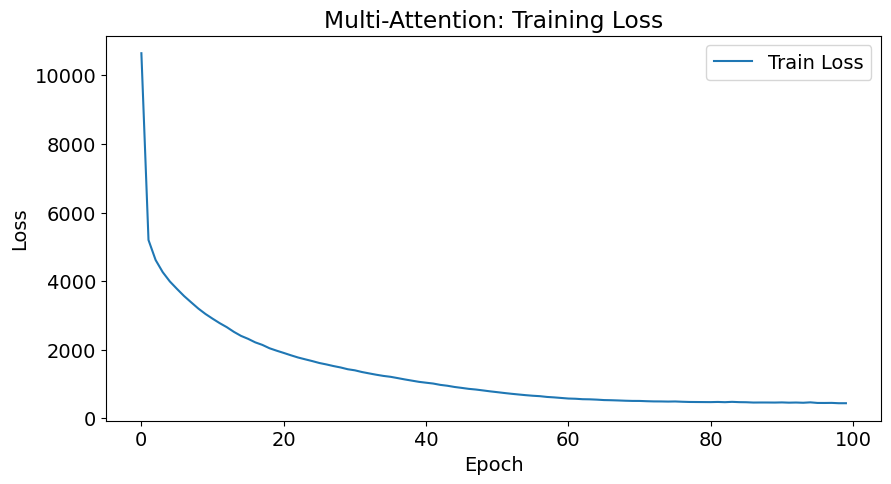

In [299]:
# Training
num_epochs = 100
model_multi_att.train()
training_losses = []

for epoch in range(num_epochs):
    train_loss = 0.
    for inputs, targets in train_loader:
        output = model_multi_att(inputs)
        loss = compute_loss(output, targets)
        train_loss += loss.item()
        
        optimizer_multi_att.zero_grad()
        accelerator.backward(loss)
        optimizer_multi_att.step()
        
    training_losses.append(train_loss)
    if (epoch+1)%10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {train_loss/len(train_loader):.4f}')
plot_loss(training_losses, 'Multi-Attention')

Test Loss: 11.5134


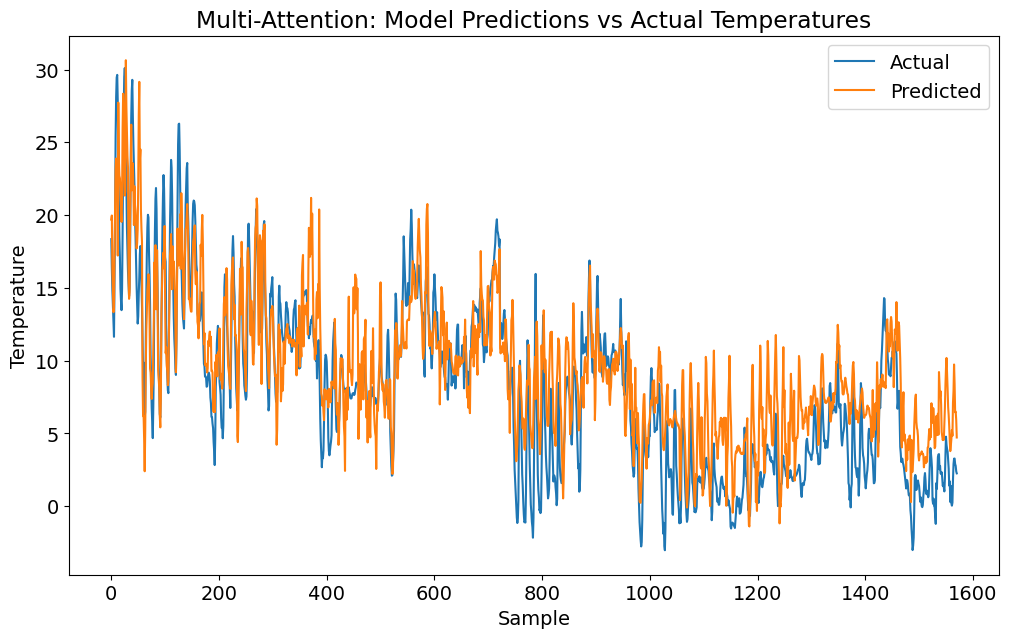

In [300]:
# Testing
model_multi_att.eval()
predictions_ma = []
actual_ma = []

with torch.no_grad():
    test_loss = 0.
    for inputs, targets in test_loader:
        output = model_multi_att(inputs)
        loss = compute_loss(output, targets)
        test_loss += loss.item()

        predictions_ma.extend(output.flatten().tolist())
        actual_ma.extend(targets.flatten().tolist())

    print(f'Test Loss: {test_loss/len(test_loader):.4f}')

predictions_ma = np.array(predictions_ma)
actual_ma = np.array(actual_ma)
plot_compare_prediction(predictions_ma, actual_ma, 'Multi-Attention')

Task 6: Encoder module and three-layer encoder-only Transformer

In [301]:
# Encoder module
class EncoderLayer(nn.Module):
    def __init__(self, D, K, N):
        super(EncoderLayer, self).__init__()
        self.UMHA = Multi_Head_Attention(D, K, N, False)
        self.conv = nn.Conv1d(D, D, kernel_size=3, padding=1)
        self.act = nn.ReLU()
        self.layernorm_ssa = nn.LayerNorm(D)
        self.layernorm_conv = nn.LayerNorm(D)

    def forward(self, X):
        X = X + self.UMHA(self.layernorm_ssa(X), self.layernorm_ssa(X), self.layernorm_ssa(X))
        X = X + self.conv(self.layernorm_conv(X).permute(0, 2, 1)).permute(0, 2, 1)
        X = self.act(X)
        return X

In [302]:
class Encoder(nn.Module):
    def __init__(self, D, K, N, num_layers):
        super(Encoder, self).__init__()
        self.encoder_layers = nn.ModuleList([EncoderLayer(D, K, N) for _ in range(num_layers)])
        self.flatten = nn.Linear(D * N, 1)
    
    def forward(self, X):
        for encoder_layer in self.encoder_layers:
            X = encoder_layer(X)
        X = X.reshape(X.shape[0], -1)
        X = self.flatten(X)
        return X.squeeze()

In [303]:
D = 12
K = 4
N = window_size
num_layers = 3

model_encoder = Encoder(D, K, N, num_layers).float()
optimizer_encoder = torch.optim.AdamW(model_encoder.parameters(), lr=1e-4)

compute_loss = nn.MSELoss()

train_loader, test_loader, model_encoder, optimizer_encoder = accelerator.prepare(
    train_loader, test_loader, model_encoder, optimizer_encoder
)

Epoch [10/150], Loss: 400.0645
Epoch [20/150], Loss: 198.1494
Epoch [30/150], Loss: 108.1482
Epoch [40/150], Loss: 61.6819
Epoch [50/150], Loss: 37.3119
Epoch [60/150], Loss: 22.4364
Epoch [70/150], Loss: 13.8699
Epoch [80/150], Loss: 9.6132
Epoch [90/150], Loss: 6.0145
Epoch [100/150], Loss: 4.5832
Epoch [110/150], Loss: 3.7132
Epoch [120/150], Loss: 3.2598
Epoch [130/150], Loss: 3.2669
Epoch [140/150], Loss: 3.4632
Epoch [150/150], Loss: 2.8087


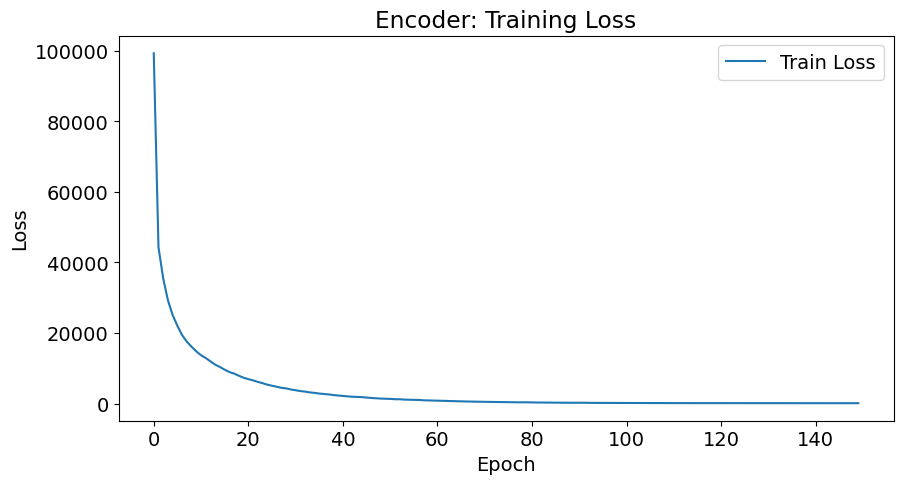

In [304]:
# Training
num_epochs = 150
model_encoder.train()
train_losses = []

for epoch in range(num_epochs):
    train_loss = 0.
    for inputs, targets in train_loader:
        output = model_encoder(inputs)
        loss = compute_loss(output, targets)
        train_loss += loss.item()
        
        optimizer_encoder.zero_grad()
        accelerator.backward(loss)
        optimizer_encoder.step()

    train_losses.append(train_loss)
    if (epoch+1)%10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {train_loss/len(train_loader):.4f}')
plot_loss(train_losses, 'Encoder')

Test Loss: 3.2258


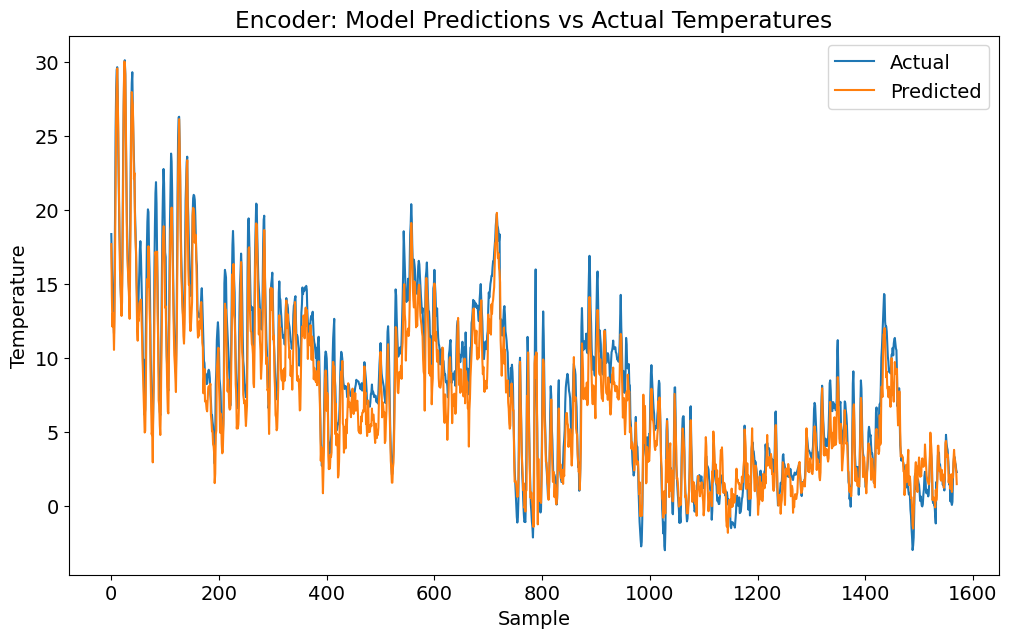

In [305]:
# Testing
model_encoder.eval()
predictions_e = []
actual_e = []

with torch.no_grad():
    test_loss = 0.
    for inputs, targets in test_loader:
        output = model_encoder(inputs)
        loss = compute_loss(output, targets)
        test_loss += loss.item()

        predictions_e.extend(output.flatten().tolist())
        actual_e.extend(targets.flatten().tolist())

    print(f'Test Loss: {test_loss/len(test_loader):.4f}')

# Visualize
predictions_e = np.array(predictions_e)
actual_e = np.array(actual_e)
plot_compare_prediction(predictions_e, actual_e, 'Encoder')

Task 7: Decoder module and three-layer decoder-only Transformer

In [306]:
# Decoder module
class DecoderLayer(nn.Module):
    def __init__(self, D, K, N):
        super(DecoderLayer, self).__init__()
        self.MMHA = Multi_Head_Attention(D, K, N, True)
        self.conv = nn.Conv1d(D, D, kernel_size=3, padding=1)
        self.act = nn.ReLU()
        self.layernorm_ssa = nn.LayerNorm(D)
        self.layernorm_conv = nn.LayerNorm(D)

    def forward(self, X_enc, X_og):
        X = X_og + self.MMHA(self.layernorm_ssa(X_og), self.layernorm_ssa(X_og), self.layernorm_ssa(X_og))
        X = X + self.MMHA(self.layernorm_ssa(X), self.layernorm_ssa(X_enc), self.layernorm_ssa(X_enc))
        X = X + self.conv(self.layernorm_conv(X).permute(0, 2, 1)).permute(0, 2, 1)
        X = self.act(X)
        return X

In [307]:
class Decoder(nn.Module):
    def __init__(self, D, K, N, num_layers):
        super(Decoder, self).__init__()
        self.decoder_layers = nn.ModuleList([DecoderLayer(D, K, N) for _ in range(num_layers)])
        self.flatten = nn.Linear(D * N, 1)
    
    def forward(self, X):
        for decoder_layer in self.decoder_layers:
            X = decoder_layer(X, X)
        X = X.reshape(X.shape[0], -1)
        X = self.flatten(X)
        return X.squeeze()

In [308]:
D = 12
K = 4
N = window_size
num_layers = 3

model_decoder = Decoder(D, K, N, num_layers).float()
optimizer_decoder = torch.optim.Adam(model_decoder.parameters(), lr=1e-4)

compute_loss = nn.MSELoss()

train_loader, test_loader, model_decoder, optimizer_decoder = accelerator.prepare(
    train_loader, test_loader, model_decoder, optimizer_decoder
)

Epoch [10/150], Loss: 543.6985
Epoch [20/150], Loss: 346.2449
Epoch [30/150], Loss: 225.1560
Epoch [40/150], Loss: 149.9121
Epoch [50/150], Loss: 99.4107
Epoch [60/150], Loss: 66.7311
Epoch [70/150], Loss: 45.0683
Epoch [80/150], Loss: 29.5329
Epoch [90/150], Loss: 19.8874
Epoch [100/150], Loss: 13.2770
Epoch [110/150], Loss: 8.5119
Epoch [120/150], Loss: 6.2092
Epoch [130/150], Loss: 4.6767
Epoch [140/150], Loss: 3.8021
Epoch [150/150], Loss: 3.2307


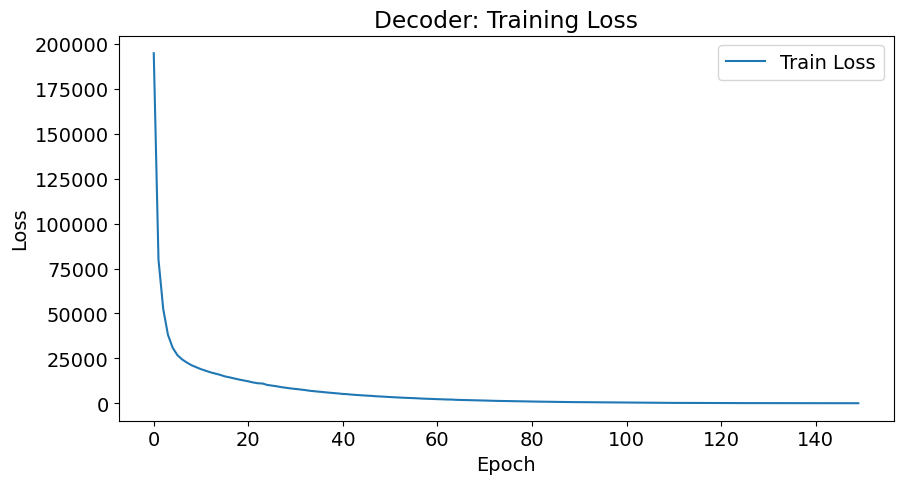

In [309]:
# Training
num_epochs = 150
model_decoder.train()
train_losses = []

for epoch in range(num_epochs):
    train_loss = 0.
    for inputs, targets in train_loader:
        output = model_decoder(inputs)
        loss = compute_loss(output, targets)
        train_loss += loss.item()
        
        optimizer_decoder.zero_grad()
        accelerator.backward(loss)
        optimizer_decoder.step()

    train_losses.append(train_loss)
    if (epoch+1)%10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {train_loss/len(train_loader):.4f}')
plot_loss(train_losses, 'Decoder')

Test Loss: 3.1103


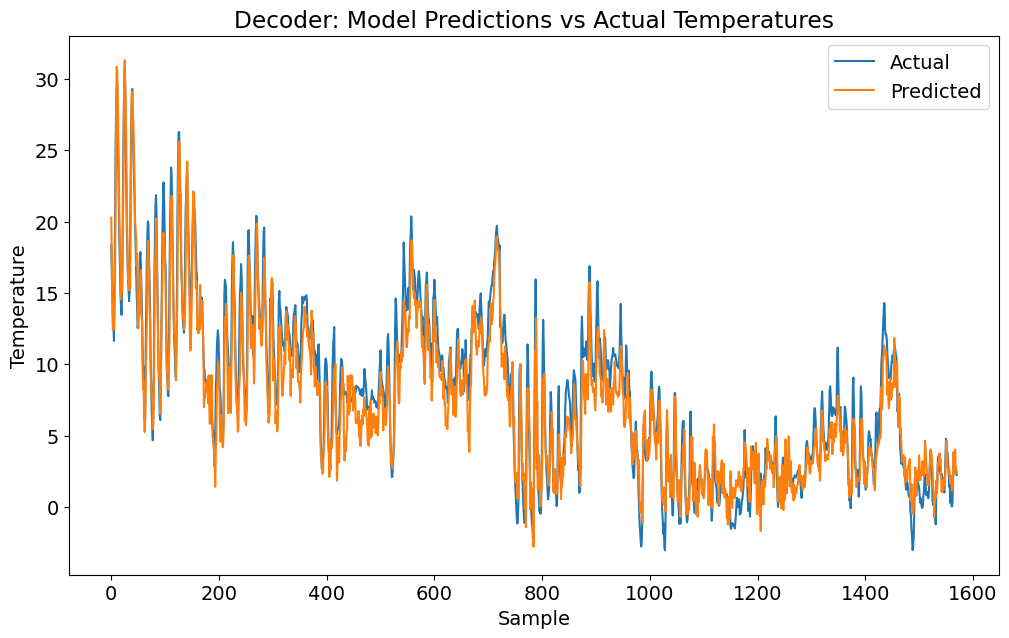

In [310]:
# Testing
model_decoder.eval()
predictions_d = []
actual_d = []

with torch.no_grad():
    test_loss = 0.
    for inputs, targets in test_loader:
        output = model_decoder(inputs)
        loss = compute_loss(output, targets)
        test_loss += loss.item()

        predictions_d.extend(output.flatten().tolist())
        actual_d.extend(targets.flatten().tolist())

    print(f'Test Loss: {test_loss/len(test_loader):.4f}')

# Visualize output
predictions_d = np.array(predictions_d)
actual_d = np.array(actual_d)
plot_compare_prediction(predictions_d, actual_d, 'Decoder')

Task 8: Full Transformer

In [311]:
class Transformer(nn.Module):
    def __init__(self, D, K, N, num_layers):
        super(Transformer, self).__init__()
        self.encoder = EncoderLayer(D, K, N)
        self.decoder = DecoderLayer(D, K, N)
        self.encoder_layers = nn.ModuleList([EncoderLayer(D, K, N) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(D, K, N) for _ in range(num_layers)])
        self.W_F = nn.Linear(D * N, 1)

    def forward(self, X):
        X_enc = X.clone()
        for encoder_layer in self.encoder_layers:
            X_enc = encoder_layer(X_enc)
        for decoder_layer in self.decoder_layers:
            X = decoder_layer(X_enc, X)
        X = X.reshape(X.shape[0], -1)
        X = self.W_F(X)
        return X.squeeze()

In [312]:
D = 12
K = 4
N = window_size
num_layers = 3

model_transformer = Transformer(D, K, N, num_layers).float()
optimizer_transformer = torch.optim.AdamW(model_transformer.parameters(), lr=1e-4)

compute_loss = nn.MSELoss()

train_loader, test_loader, model_transformer, optimizer_transformer = accelerator.prepare(
    train_loader, test_loader, model_transformer, optimizer_transformer
)

Epoch [10/150], Loss: 375.4702
Epoch [20/150], Loss: 182.6726
Epoch [30/150], Loss: 97.9080
Epoch [40/150], Loss: 55.8250
Epoch [50/150], Loss: 34.0849
Epoch [60/150], Loss: 21.1275
Epoch [70/150], Loss: 13.3322
Epoch [80/150], Loss: 8.3751
Epoch [90/150], Loss: 5.6328
Epoch [100/150], Loss: 4.2322
Epoch [110/150], Loss: 3.3156
Epoch [120/150], Loss: 3.1468
Epoch [130/150], Loss: 2.7278
Epoch [140/150], Loss: 2.8633
Epoch [150/150], Loss: 2.5097


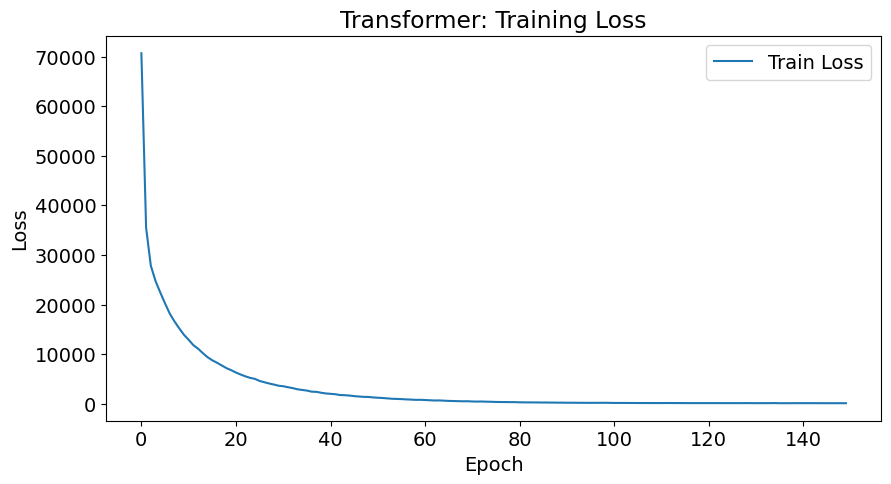

In [313]:
# Training
num_epochs = 150
model_transformer.train()
training_losses = []

for epoch in range(num_epochs):
    train_loss = 0.
    for inputs, targets in train_loader:
        output = model_transformer(inputs)
        loss = compute_loss(output, targets)
        train_loss += loss.item()
        
        optimizer_transformer.zero_grad()
        accelerator.backward(loss)
        optimizer_transformer.step()

    training_losses.append(train_loss)
    if (epoch+1)%10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {train_loss/len(train_loader):.4f}')
plot_loss(training_losses, 'Transformer')

Test Loss: 2.2192


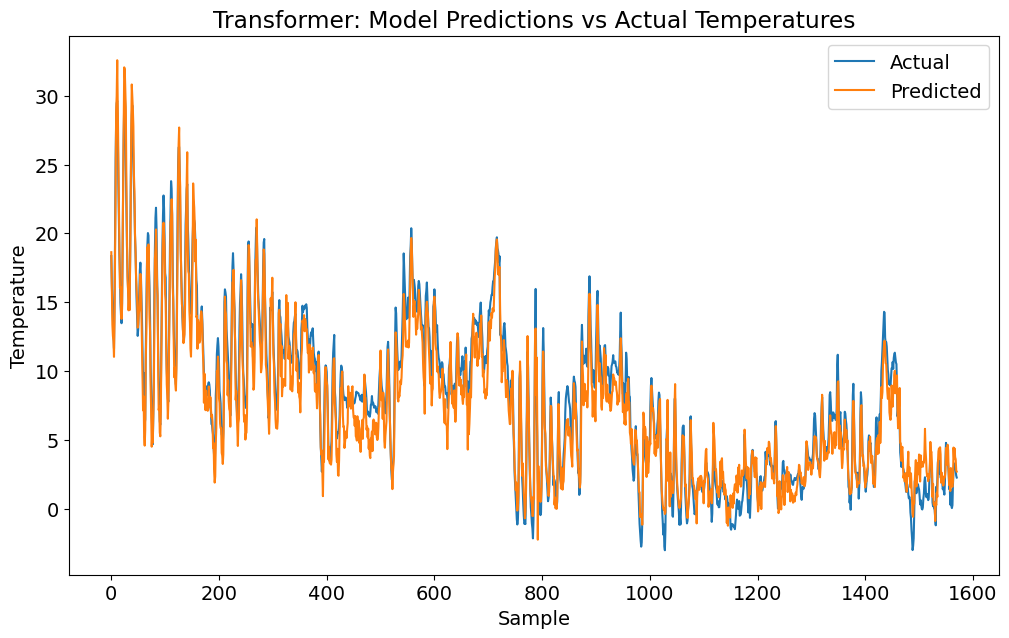

In [314]:
# Testing
model_transformer.eval()
predictions_t = []
actual_t = []

with torch.no_grad():
    test_loss = 0.
    for inputs, targets in test_loader:
        output = model_transformer(inputs)
        loss = compute_loss(output, targets)
        test_loss += loss.item()

        predictions_t.extend(output.flatten().tolist())
        actual_t.extend(targets.flatten().tolist())

    print(f'Test Loss: {test_loss/len(test_loader):.4f}')

# Visualize output
predictions_t = np.array(predictions_t)
actual_t = np.array(actual_t)
plot_compare_prediction(predictions_t, actual_t, 'Transformer')